## Project on Flood Disaster Data Analysis Using Pyspark
## Dataset: urbal_pluvial_flood_risk_dataset
## Source: https://www.kaggle.com/datasets/emanfatima2025/flood-disaster-data

In [201]:
sc

<SparkContext master=local[*] appName=PySparkShell>

# Data Insights
The dataset contains 2,963 records with 17 attributes:segment_id, city_name, admin_ward, latitude, longitude, catchment_id, elevation_m, dem_source, land_use, soil_group, drainage_density_km_per_km2, storm_drain_proximity_m, storm_drain_type, rainfall_source, historical_rainfall_intensity_mm_hr, return_period_years, risk_labels.

## 1. Elevation & Hydrological Factors

Elevation ranges from -3 m (below sea level) to 266.7 m, with an average of ~38 m.

Drainage density varies between 1.27 and 12.07 km/km², with an average of ~6.3 km/km².

Storm drain proximity averages ~123 m but can be as far as 751 m, indicating highly variable urban infrastructure access.

Rainfall intensity ranges from 5.4 mm/hr (low risk) to 150 mm/hr (extreme storm events).

## 2. Risk Labels & Flood Vulnerability

The most common label is “monitor” (1991 records, ~67%), indicating areas flagged for continuous observation.

Low-lying areas (386 records, ~13%) and extreme rain history (137 records, ~5%) highlight specific high-risk categories.

Combined categories such as “ponding_hotspot|low_lying” (78 records) suggest complex multi-factor risks.

## 3. Land Use & Soil Characteristics

Land use: Residential (827), Roads (599), Commercial (493), Green (359), Industrial (357).
→ Residential and road areas dominate, implying high urban exposure to flooding.

Soil groups:

B (747) and C (713) dominate, with moderate infiltration capacity.

D (594) represents high runoff risk soils, common in flood-prone areas.

A (547) soils (sandy, high infiltration) are least flood-prone.

## 4. Storm Drain Infrastructure

Curb Inlets (843) and Manholes (749) are most common.

Grated Inlets (644) and Open Channels (549) also feature significantly.

178 records have no storm drainage, representing critical flood risk hotspots.

## 5. Geographic Coverage

Cities include Manila (61 records), San Francisco (60), Philadelphia (59), Seoul (58), and Athens (58).

Admin wards like Zone V (82) and Old Town Borough (71) have the most entries.

Catchment areas vary, with some like CAT-012 (28 records) dominating.

## 6. Key Patterns

Low elevation + soil group D + poor drainage → strong flood vulnerability.

Rainfall intensity and return period: Some locations experience extreme rainfall events (≥100 mm/hr) with short return periods, compounding flood risks.

Land use & flood risk: Residential and commercial zones dominate high-risk categories.

Storm drain absence in urban cores contributes to ponding hotspots.

## 7. Overall Insights

The dataset provides a multi-dimensional view of urban flood risks:

Flood risk is concentrated in residential and road-heavy zones with soil types B–D.

Stormwater infrastructure gaps (esp. where storm_drain_type = None) exacerbate risks.

Cities like Manila, San Francisco, and Philadelphia show significant exposure.

Majority of areas fall under “monitor” but low-lying and extreme rainfall regions require urgent interventions.

In [202]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, mean, desc

# Step 2: Initialize Spark Session
spark = SparkSession.builder.appName("Urban_Flood_Risk_Analysis").getOrCreate()

# Step 3: Load Dataset
df = spark.read.csv("urban_pluvial_flood_risk_dataset.csv", header=True, inferSchema=True)

In [203]:
# Step 4: Show Sample Records and Schema
print("=== First 10 Rows of Dataset ===")
df.show(10)

=== First 10 Rows of Dataset ===
+----------+--------------------+-----------+---------+----------+------------+-----------+--------------------+-------------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+--------------------+
|segment_id|           city_name| admin_ward| latitude| longitude|catchment_id|elevation_m|          dem_source|     land_use|soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|         risk_labels|
+----------+--------------------+-----------+---------+----------+------------+-----------+--------------------+-------------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+--------------------+
| SEG-02207|      Lagos, Nigeria|  Sector 14| 6.452143|  3.451479| 

In [204]:
print("=== Schema of Dataset ===")
df.printSchema()

=== Schema of Dataset ===
root
 |-- segment_id: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- admin_ward: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- catchment_id: string (nullable = true)
 |-- elevation_m: double (nullable = true)
 |-- dem_source: string (nullable = true)
 |-- land_use: string (nullable = true)
 |-- soil_group: string (nullable = true)
 |-- drainage_density_km_per_km2: double (nullable = true)
 |-- storm_drain_proximity_m: double (nullable = true)
 |-- storm_drain_type: string (nullable = true)
 |-- rainfall_source: string (nullable = true)
 |-- historical_rainfall_intensity_mm_hr: double (nullable = true)
 |-- return_period_years: integer (nullable = true)
 |-- risk_labels: string (nullable = true)



In [205]:
# Step 6: Count total records
print("\n=== Total Number of Records ===")
print(df.count())


=== Total Number of Records ===
1000


In [206]:
from pyspark.sql.types import NumericType, StringType

# Step 7 (fixed): Missing values per column
print("\n=== Missing Values per Column (safe check) ===")

missing_counts = []
for c in df.columns:
    # If column is numeric → check null OR isnan
    if isinstance(df.schema[c].dataType, NumericType):
        missing_counts.append(count(when(col(c).isNull() | isnan(col(c)), c)).alias(c))
    else:
        # For string columns → only check nulls
        missing_counts.append(count(when(col(c).isNull(), c)).alias(c))

df.select(missing_counts).show()



=== Missing Values per Column (safe check) ===
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
|segment_id|city_name|admin_ward|latitude|longitude|catchment_id|elevation_m|dem_source|land_use|soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|risk_labels|
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
|         0|        0|         0|       0|        0|           0|         50|         0|       0|       115|                         94|                     88|      

In [207]:
# Replace nulls in all string columns with "Unknown"
df = df.fillna("Unknown")

# Replace nulls in numeric columns with 0
df = df.fillna(0)

In [208]:
# Step 5: Dataset Summary
print("=== Basic Statistics ===")
df.describe().show()

=== Basic Statistics ===
+-------+----------+------------------+---------------+------------------+-----------------+------------+------------------+--------------------+----------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+--------------------+
|summary|segment_id|         city_name|     admin_ward|          latitude|        longitude|catchment_id|       elevation_m|          dem_source|  land_use|soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|         risk_labels|
+-------+----------+------------------+---------------+------------------+-----------------+------------+------------------+--------------------+----------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-------

In [209]:
# Step 7: Count Total Records and Columns
print(f"Total Rows: {df.count()}")
print(f"Total Columns: {len(df.columns)}")

Total Rows: 1000
Total Columns: 17


In [210]:
# Step 8: Display Column Names
print("=== Columns in Dataset ===")
print(df.columns)

=== Columns in Dataset ===
['segment_id', 'city_name', 'admin_ward', 'latitude', 'longitude', 'catchment_id', 'elevation_m', 'dem_source', 'land_use', 'soil_group', 'drainage_density_km_per_km2', 'storm_drain_proximity_m', 'storm_drain_type', 'rainfall_source', 'historical_rainfall_intensity_mm_hr', 'return_period_years', 'risk_labels']


In [211]:
# Locations with HIGH flood risk
print("=== Locations with HIGH flood risk ===")
df.filter(df["risk_labels"] == "High").show(10, truncate=False)

=== Locations with HIGH flood risk ===
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
|segment_id|city_name|admin_ward|latitude|longitude|catchment_id|elevation_m|dem_source|land_use|soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|risk_labels|
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+---------------

In [212]:
# Locations with rainfall intensity greater than 100 mm/hr
print("\n=== Locations with Rainfall Intensity > 100 mm/hr ===")
df.filter(df["historical_rainfall_intensity_mm_hr"] > 100).show(10, truncate=False)


=== Locations with Rainfall Intensity > 100 mm/hr ===
+----------+-------------------------+----------------+----------+----------+------------+-----------+-----------------------+-----------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------------------------------------------------+
|segment_id|city_name                |admin_ward      |latitude  |longitude |catchment_id|elevation_m|dem_source             |land_use   |soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|risk_labels                                          |
+----------+-------------------------+----------------+----------+----------+------------+-----------+-----------------------+-----------+----------+---------------------------+-----------------------+----------------+---------------+---------------------

In [213]:
# Locations with rainfall intensity greater than 100 mm/hr
print("\n=== Locations with Rainfall Intensity > 100 mm/hr ===")
df.filter(df["historical_rainfall_intensity_mm_hr"] > 100).show(10, truncate=False)


=== Locations with Rainfall Intensity > 100 mm/hr ===
+----------+-------------------------+----------------+----------+----------+------------+-----------+-----------------------+-----------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------------------------------------------------+
|segment_id|city_name                |admin_ward      |latitude  |longitude |catchment_id|elevation_m|dem_source             |land_use   |soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|risk_labels                                          |
+----------+-------------------------+----------------+----------+----------+------------+-----------+-----------------------+-----------+----------+---------------------------+-----------------------+----------------+---------------+---------------------

In [214]:
# Low elevation (<10 m) locations
print("\n=== Locations with Elevation < 10 meters ===")
df.filter(df["elevation_m"] < 10).show(10, truncate=False)


=== Locations with Elevation < 10 meters ===
+----------+-----------------------+---------------+---------+----------+------------+-----------+-----------------------+-------------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+--------------------------+
|segment_id|city_name              |admin_ward     |latitude |longitude |catchment_id|elevation_m|dem_source             |land_use     |soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|risk_labels               |
+----------+-----------------------+---------------+---------+----------+------------+-----------+-----------------------+-------------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+--------------------------+
|SEG-0

In [215]:
# Areas with storm drain type = 'Open'
print("\n=== Locations with Open Storm Drains ===")
df.filter(df["storm_drain_type"] == "Open").show(10, truncate=False)


=== Locations with Open Storm Drains ===
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
|segment_id|city_name|admin_ward|latitude|longitude|catchment_id|elevation_m|dem_source|land_use|soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|risk_labels|
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
+----------+---------+----------+--------+---------+------------+-----------+----------+--------+----------+---------------------------+-----------------------+------------

In [216]:
# Cities with more than one segment (group by + count > 1)
print("\n=== Cities with multiple segments in dataset ===")
df.groupBy("city_name").count().filter(col("count") > 1).orderBy(col("count").desc()).show(10, truncate=False)


=== Cities with multiple segments in dataset ===
+----------------------+-----+
|city_name             |count|
+----------------------+-----+
|Shenzhen, China       |25   |
|Rotterdam, Netherlands|25   |
|Dhaka, Bangladesh     |24   |
|Delhi, India          |24   |
|Manila, Philippines   |23   |
|Riyadh, Saudi Arabia  |22   |
|Philadelphia, USA     |22   |
|Paris, France         |22   |
|Lagos, Nigeria        |21   |
|Lima, Peru            |21   |
+----------------------+-----+
only showing top 10 rows


In [217]:
# Show distinct soil groups
print("=== Unique Soil Groups ===")
df.select("soil_group").distinct().show(10, truncate=False)

=== Unique Soil Groups ===
+----------+
|soil_group|
+----------+
|B         |
|Unknown   |
|D         |
|C         |
|A         |
+----------+



In [218]:
# Count records for each soil group
print("\n=== Count of Records by Soil Group ===")
df.groupBy("soil_group").count().orderBy(col("count").desc()).show(10, truncate=False)


=== Count of Records by Soil Group ===
+----------+-----+
|soil_group|count|
+----------+-----+
|B         |258  |
|C         |232  |
|D         |208  |
|A         |187  |
|Unknown   |115  |
+----------+-----+



In [219]:
# Locations with soil group = 'A'
print("\n=== Locations with Soil Group = A ===")
df.filter(col("soil_group") == "A").show(10, truncate=False)


=== Locations with Soil Group = A ===
+----------+-----------------------+-----------+----------+----------+------------+-----------+-----------------------+-----------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
|segment_id|city_name              |admin_ward |latitude  |longitude |catchment_id|elevation_m|dem_source             |land_use   |soil_group|drainage_density_km_per_km2|storm_drain_proximity_m|storm_drain_type|rainfall_source|historical_rainfall_intensity_mm_hr|return_period_years|risk_labels|
+----------+-----------------------+-----------+----------+----------+------------+-----------+-----------------------+-----------+----------+---------------------------+-----------------------+----------------+---------------+-----------------------------------+-------------------+-----------+
|SEG-01314 |Rotterdam, Netherlands |Ward G     |51.972605 |4.583407  |CAT

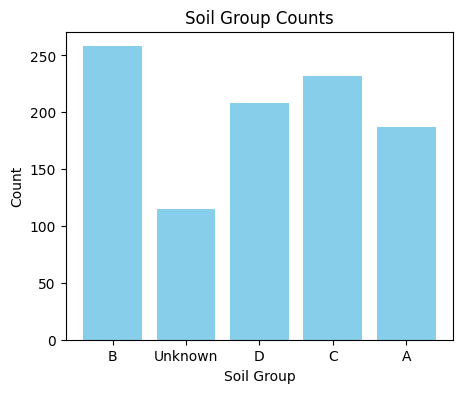

In [220]:
soil_counts = df.groupBy("soil_group").count().toPandas()

plt.figure(figsize=(5,4))
plt.bar(soil_counts["soil_group"], soil_counts["count"], color="skyblue")
plt.title("Soil Group Counts")
plt.xlabel("Soil Group")
plt.ylabel("Count")
plt.show()


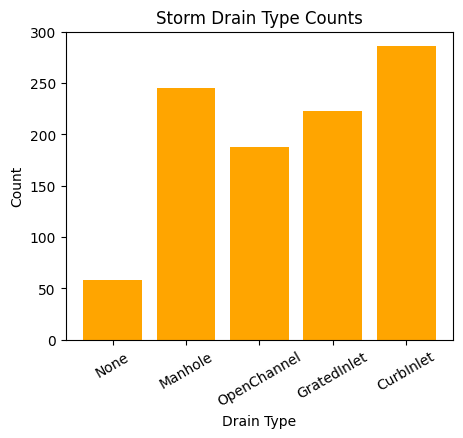

In [221]:
drain_counts = df.groupBy("storm_drain_type").count().toPandas()

plt.figure(figsize=(5,4))
plt.bar(drain_counts["storm_drain_type"], drain_counts["count"], color="orange")
plt.title("Storm Drain Type Counts")
plt.xlabel("Drain Type")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


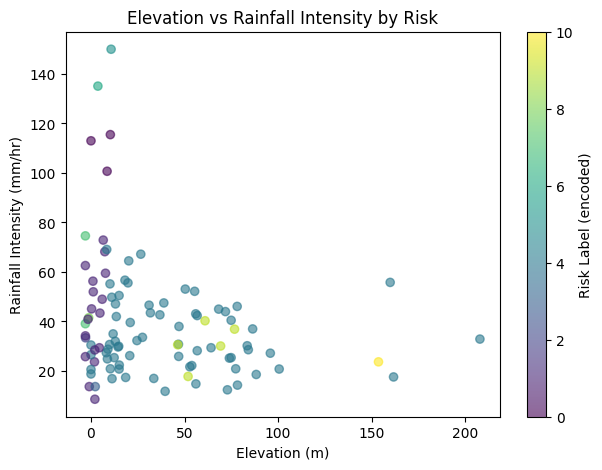

In [222]:
# Convert subset to Pandas (for performance)
subset = df.select("elevation_m", "historical_rainfall_intensity_mm_hr", "risk_labels").sample(False, 0.1).toPandas()

# Plot
plt.figure(figsize=(7,5))
plt.scatter(subset["elevation_m"], subset["historical_rainfall_intensity_mm_hr"],
            c=subset["risk_labels"].astype("category").cat.codes, cmap="viridis", alpha=0.6)
plt.colorbar(label="Risk Label (encoded)")
plt.title("Elevation vs Rainfall Intensity by Risk")
plt.xlabel("Elevation (m)")
plt.ylabel("Rainfall Intensity (mm/hr)")
plt.show()


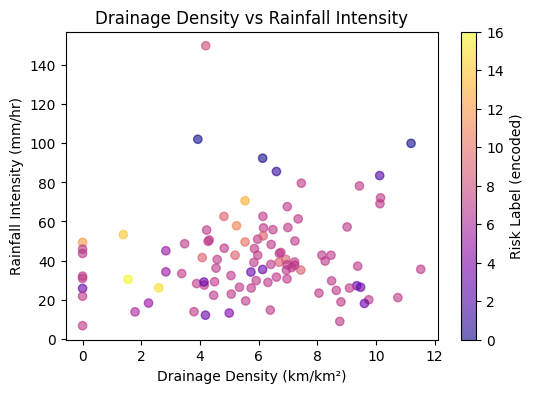

In [223]:
subset = df.select("drainage_density_km_per_km2", "historical_rainfall_intensity_mm_hr", "risk_labels") \
           .sample(False, 0.1).toPandas()

plt.figure(figsize=(6,4))
plt.scatter(subset["drainage_density_km_per_km2"], subset["historical_rainfall_intensity_mm_hr"],
            c=subset["risk_labels"].astype("category").cat.codes, cmap="plasma", alpha=0.6)
plt.title("Drainage Density vs Rainfall Intensity")
plt.xlabel("Drainage Density (km/km²)")
plt.ylabel("Rainfall Intensity (mm/hr)")
plt.colorbar(label="Risk Label (encoded)")
plt.show()


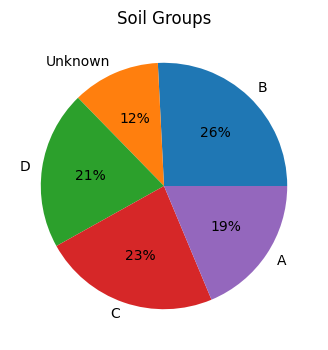

In [224]:
soil_counts = df.groupBy("soil_group").count().toPandas()

plt.figure(figsize=(4,4))
plt.pie(soil_counts["count"], labels=soil_counts["soil_group"], autopct="%1.0f%%")
plt.title("Soil Groups")
plt.show()


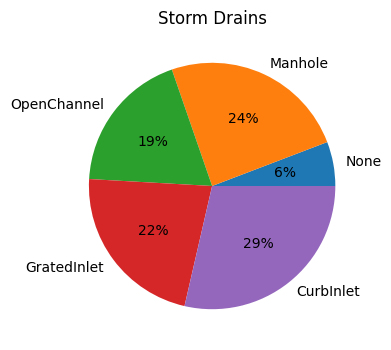

In [225]:
drain_counts = df.groupBy("storm_drain_type").count().toPandas()

plt.figure(figsize=(4,4))
plt.pie(drain_counts["count"], labels=drain_counts["storm_drain_type"], autopct="%1.0f%%")
plt.title("Storm Drains")
plt.show()


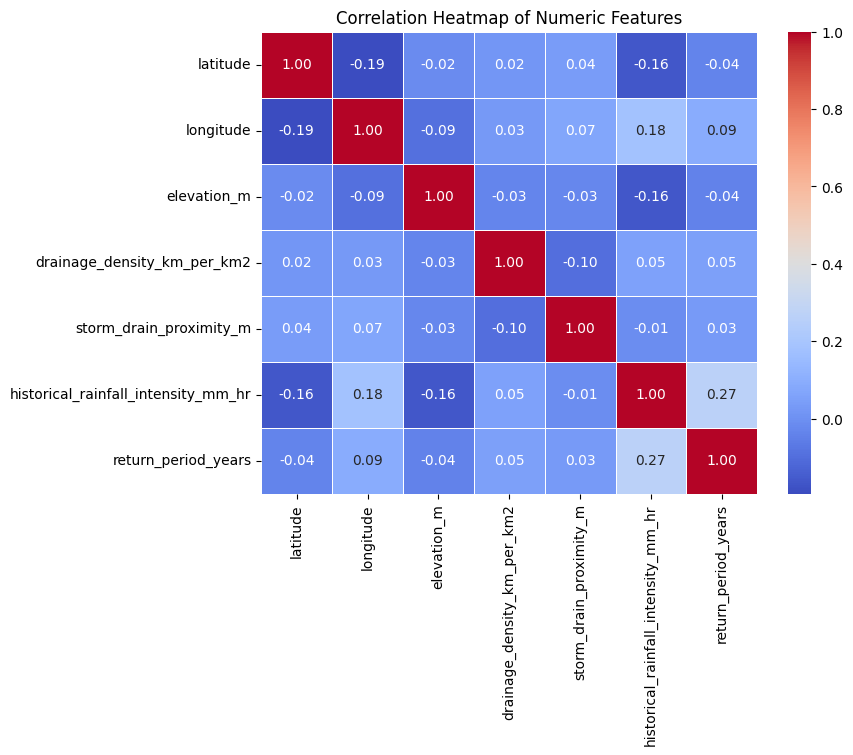

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import NumericType

# 1. Get numeric columns only
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# 2. Convert to Pandas (sample if dataset is very large)
pdf = df.select(numeric_cols).toPandas()

# 3. Compute correlation matrix
corr_matrix = pdf.corr()

# 4. Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


# Conclusion

The dataset shows that low elevation, poor soil infiltration (Group D), and lack of storm drains are the main drivers of flood risk.
Residential and road areas face the greatest exposure, while cities like Manila, San Francisco, and Philadelphia emerge as hotspots.
Targeted drainage improvements and monitoring are essential to reduce urban flood vulnerability.